# CS 440/540: Deep Learning: Computational Structures and Programming Assignment 2

## Set up Datasets (training/test)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Image Examples

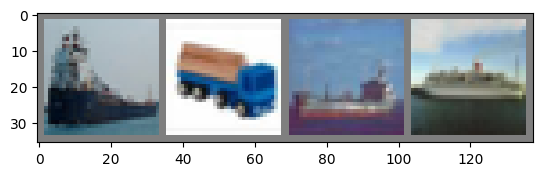

ship  truck ship  ship 


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Set up CNN w/LeNet Architecture

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNet(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if activation == "relu":
            self.act = F.sigmoid
        elif activation == "tanh":
            self.act = F.tanh
        else:
            raise ValueError("Activation must be `relu` or `tanh`")
        
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

lrs = [0.1, 0.01, 0.001]
activations = ["sigmoid", "tanh"]
losses = [nn.CrossEntropyLoss(), nn.MSELoss()]

## Test all 12 Cases

In [12]:
import torch.optim as optim
import torch.nn.functional as F

lrs = [0.1, 0.01, 0.001]
activations = ["sigmoid", "tanh"]
loss_fns = {
    "ce": nn.CrossEntropyLoss(),
    "mse": nn.MSELoss()
}

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

def run_experiment(lr, activation, loss_name, epochs=20, device="cpu"):
    net = CNet(activation=activation).to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    criterion = loss_fns[loss_name]

    for epoch in range(epochs):
        # ---- TRAIN ----
        net.train()
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            if loss_name == "mse":
                labels_oh = one_hot(labels).to(device)
                loss = criterion(outputs, labels_oh)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # ---- TEST ----
        net.eval()
        running_test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                if loss_name == "mse":
                    labels_oh = one_hot(labels).to(device)
                    loss = criterion(outputs, labels_oh)
                else:
                    loss = criterion(outputs, labels)

                running_test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = running_test_loss / len(testloader)
        acc = 100 * correct / total
        test_losses.append(avg_test_loss)

        print(f"[lr={lr}, act={activation}, loss={loss_name}] "
              f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
              f"Test Loss={avg_test_loss:.4f}, Acc={acc:.2f}%")

    return train_losses, test_losses


In [5]:
results = {}

for lr in lrs:
    for activation in activations:
        for loss_name in ["ce", "mse"]:
            key = f"lr={lr}_act={activation}_loss={loss_name}"
            print("\nRunning:", key)
            train_curve, test_curve = run_experiment(lr, activation, loss_name, epochs=20)
            results[key] = {
                "train": train_curve,
                "test": test_curve
            }



Running: lr=0.1_act=sigmoid_loss=ce
[lr=0.1, act=sigmoid, loss=ce] Epoch 1: Train Loss=2.3109, Test Loss=2.3077, Acc=10.00%
[lr=0.1, act=sigmoid, loss=ce] Epoch 2: Train Loss=2.3032, Test Loss=2.1930, Acc=18.63%
[lr=0.1, act=sigmoid, loss=ce] Epoch 3: Train Loss=1.9850, Test Loss=1.7817, Acc=32.92%
[lr=0.1, act=sigmoid, loss=ce] Epoch 4: Train Loss=1.6565, Test Loss=1.5180, Acc=43.43%
[lr=0.1, act=sigmoid, loss=ce] Epoch 5: Train Loss=1.4331, Test Loss=1.3577, Acc=49.40%
[lr=0.1, act=sigmoid, loss=ce] Epoch 6: Train Loss=1.3134, Test Loss=1.2772, Acc=53.79%
[lr=0.1, act=sigmoid, loss=ce] Epoch 7: Train Loss=1.2289, Test Loss=1.2279, Acc=55.66%
[lr=0.1, act=sigmoid, loss=ce] Epoch 8: Train Loss=1.1699, Test Loss=1.2462, Acc=56.47%
[lr=0.1, act=sigmoid, loss=ce] Epoch 9: Train Loss=1.1211, Test Loss=1.1945, Acc=57.42%
[lr=0.1, act=sigmoid, loss=ce] Epoch 10: Train Loss=1.0779, Test Loss=1.1303, Acc=59.88%
[lr=0.1, act=sigmoid, loss=ce] Epoch 11: Train Loss=1.0394, Test Loss=1.0923, Acc=

# Plot

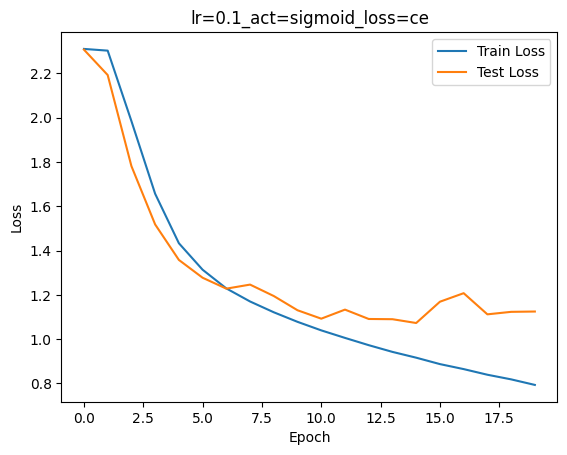

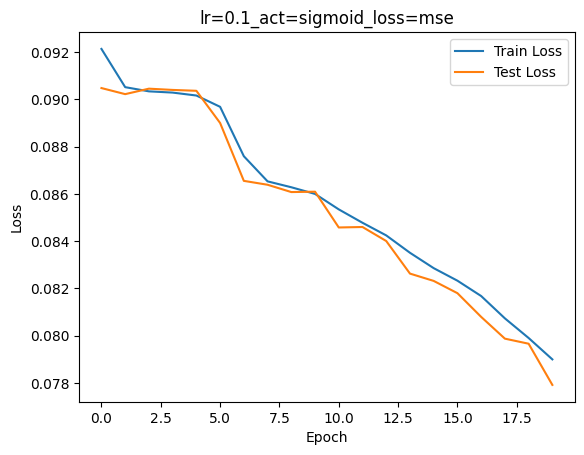

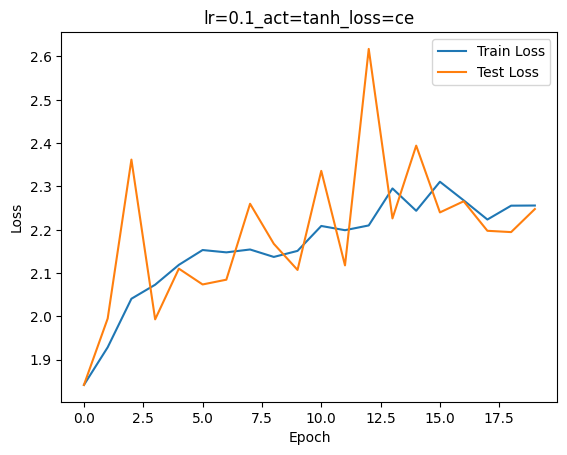

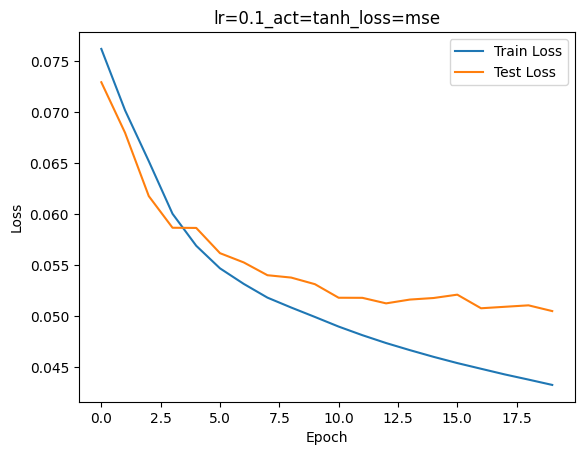

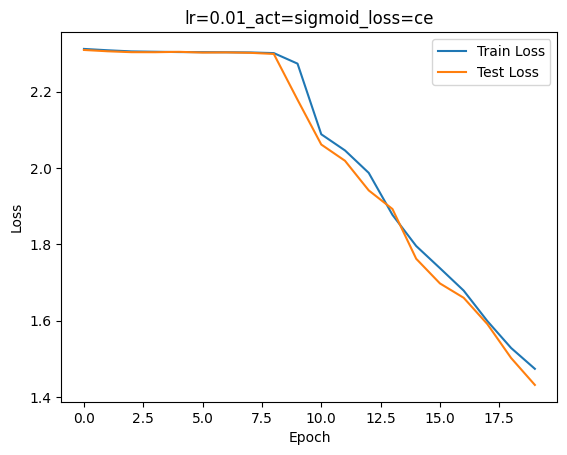

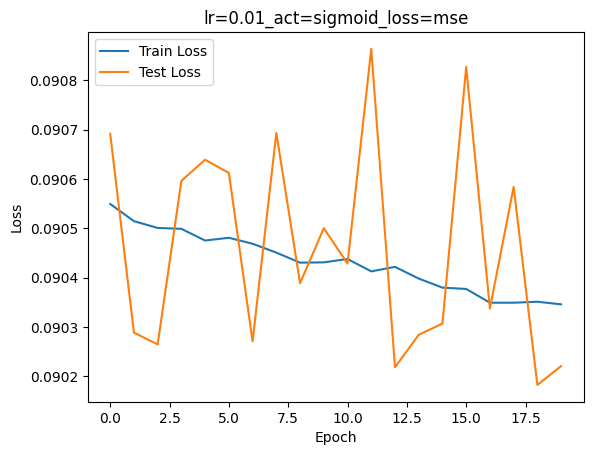

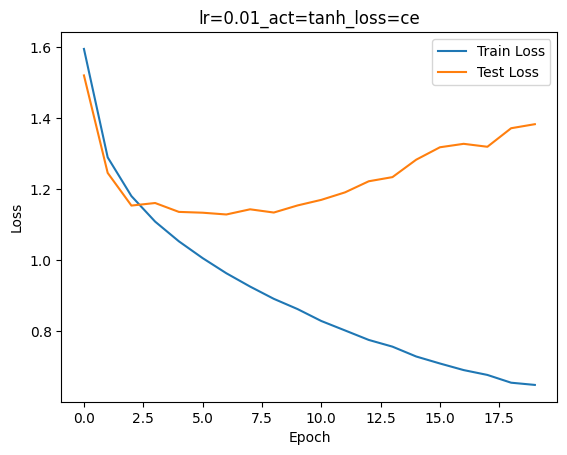

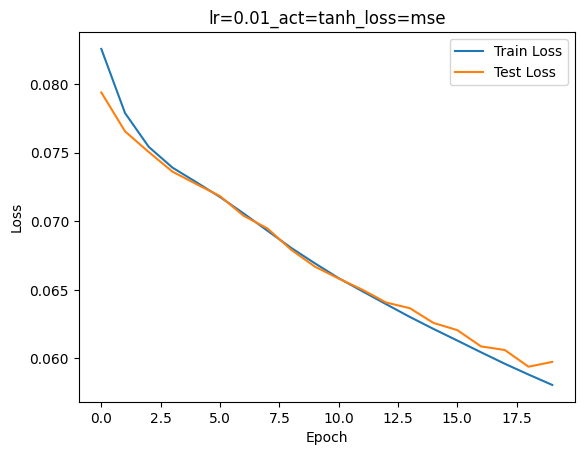

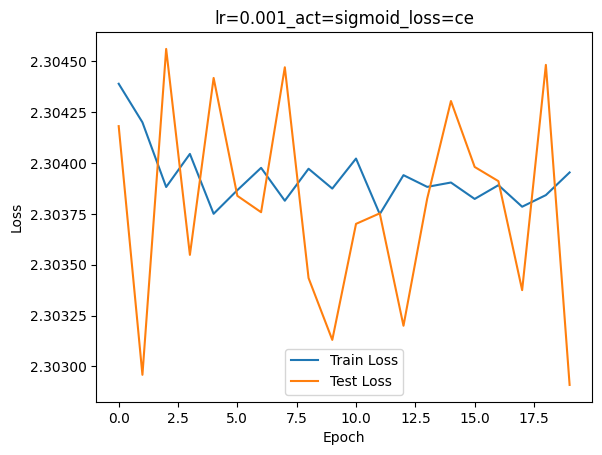

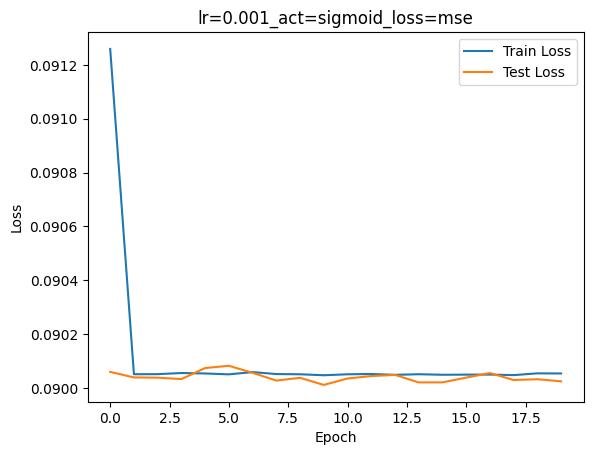

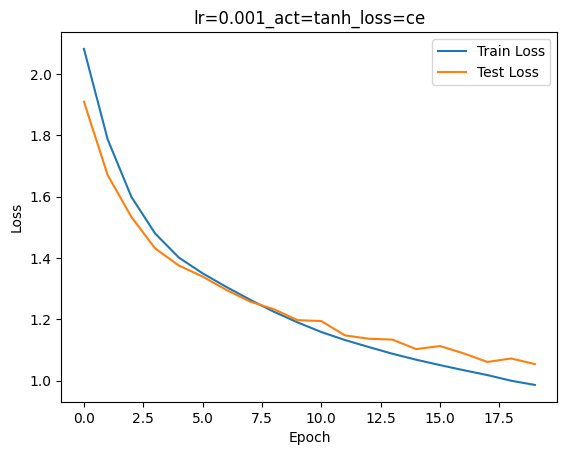

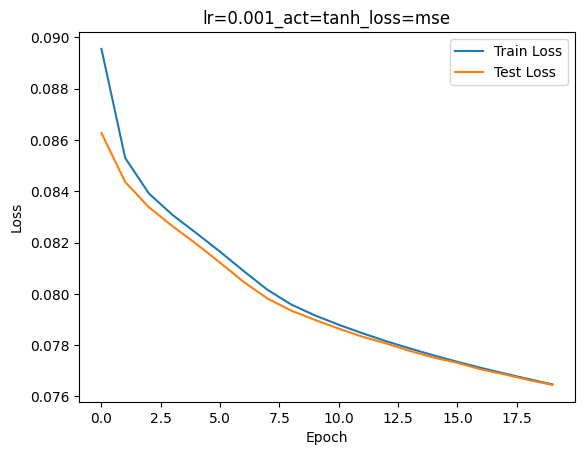

In [6]:
import matplotlib.pyplot as plt

for k, v in results.items():
    plt.figure()
    plt.plot(v["train"], label="Train Loss")
    plt.plot(v["test"], label="Test Loss")
    plt.title(k)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
def visualize_feature_maps(net, images):
    net.eval()
    with torch.no_grad():
        x = net.pool(net.act(net.conv1(images)))
        x = net.pool(net.act(net.conv2(x)))  # last conv layer output

    feature_maps = x[0]  # take first image
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(feature_maps[i].cpu(), cmap="gray")
        ax.axis("off")

    plt.suptitle("Feature Maps from Last Conv Layer")
    plt.show()



# Section 2

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNet2(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1)   # 32x32 -> 30x30
        self.pool = nn.MaxPool2d(2, 2)              # 30x30 -> 15x15
        self.conv2 = nn.Conv2d(6, 16, 3)            # 15x15 -> 13x13
                                                      # pool -> 6x6
        self.fc1 = nn.Linear(16 * 6 * 6, 120)       # Adjusted input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if activation == "sigmoid":
            self.act = torch.sigmoid
        elif activation == "tanh":
            self.act = torch.tanh
        elif activation == "relu":
            self.act = torch.relu
        else:
            raise ValueError("Activation must be `sigmoid` or `tanh`")

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)  # logits (for CE)
        return x


In [18]:
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

def run_experiment(lr, activation, loss_name, epochs=20, device="cpu"):
    net = CNet2(activation=activation).to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    criterion = loss_fns[loss_name]

    for epoch in range(epochs):
        # ---- TRAIN ----
        net.train()
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            if loss_name == "mse":
                labels_oh = one_hot(labels).to(device)
                loss = criterion(outputs, labels_oh)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # ---- TEST ----
        net.eval()
        running_test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                if loss_name == "mse":
                    labels_oh = one_hot(labels).to(device)
                    loss = criterion(outputs, labels_oh)
                else:
                    loss = criterion(outputs, labels)

                running_test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = running_test_loss / len(testloader)
        acc = 100 * correct / total
        test_losses.append(avg_test_loss)

        print(f"[lr={lr}, act={activation}, loss={loss_name}] "
              f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
              f"Test Loss={avg_test_loss:.4f}, Acc={acc:.2f}%")

    return train_losses, test_losses

[lr=0.001, act=relu, loss=ce] Epoch 1: Train Loss=2.2910, Test Loss=2.2309, Acc=16.24%
[lr=0.001, act=relu, loss=ce] Epoch 2: Train Loss=2.0221, Test Loss=1.8468, Acc=31.45%
[lr=0.001, act=relu, loss=ce] Epoch 3: Train Loss=1.7285, Test Loss=1.6035, Acc=40.60%
[lr=0.001, act=relu, loss=ce] Epoch 4: Train Loss=1.5529, Test Loss=1.4856, Acc=46.04%
[lr=0.001, act=relu, loss=ce] Epoch 5: Train Loss=1.4506, Test Loss=1.4366, Acc=47.98%
[lr=0.001, act=relu, loss=ce] Epoch 6: Train Loss=1.3819, Test Loss=1.3301, Acc=52.01%
[lr=0.001, act=relu, loss=ce] Epoch 7: Train Loss=1.3240, Test Loss=1.3102, Acc=52.91%
[lr=0.001, act=relu, loss=ce] Epoch 8: Train Loss=1.2736, Test Loss=1.2697, Acc=54.67%
[lr=0.001, act=relu, loss=ce] Epoch 9: Train Loss=1.2288, Test Loss=1.2338, Acc=56.59%
[lr=0.001, act=relu, loss=ce] Epoch 10: Train Loss=1.1898, Test Loss=1.2221, Acc=56.41%
[lr=0.001, act=relu, loss=ce] Epoch 11: Train Loss=1.1530, Test Loss=1.1741, Acc=58.64%
[lr=0.001, act=relu, loss=ce] Epoch 12: T

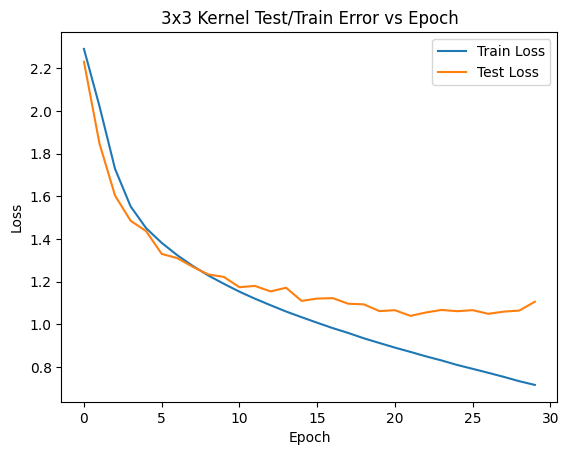

In [20]:
lr = 0.001
activation = "relu"
loss_name = "ce"
train_curve, test_curve = run_experiment(lr, activation, loss_name, epochs=30)


plt.figure()
plt.plot(train_curve, label="Train Loss")
plt.plot(test_curve, label="Test Loss")
plt.title("3x3 Kernel Test/Train Error vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Section 3

## Set up Data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Download Dow Jones data and save as CSV
ticker = "^DJI"
start_date = "2000-01-01"
end_date = "2023-12-31"

# Download data using yfinance
data = yf.download(ticker, start=start_date, end=end_date)
data.to_csv("dow_jones_data.csv")

# Step 2: Preprocess the data
# Load the data
df = pd.read_csv("dow_jones_data.csv")
high_prices = df["High"].values.reshape(-1, 1)

# Normalize the data using PyTorch
high_prices = torch.tensor(high_prices, dtype=torch.float32)
min_val = torch.min(high_prices)
max_val = torch.max(high_prices)
normalized_data = (high_prices - min_val) / (max_val - min_val)

# Split into train, validation, and test sets
train_size = int(len(normalized_data) * 0.7)
val_size = int(len(normalized_data) * 0.15)

train_data = normalized_data[:train_size]
val_data = normalized_data[train_size:train_size + val_size]
test_data = normalized_data[train_size + val_size:]

# Step 3: Prepare data for RNN
def create_sequences(data, sequence_length=100):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return torch.stack(X), torch.stack(y)

sequence_length = 100
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)





## Create RNN

In [ ]:
# Step 4: Build the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

input_size = 1
hidden_size = 50
output_size = 1

model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Train Model

In [ ]:
# Step 5: Train the model
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)  # Add channel dimension
        y_batch = y_batch.unsqueeze(-1)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.unsqueeze(-1)  # Add channel dimension
            y_batch = y_batch.unsqueeze(-1)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


# Model Eval

In [ ]:
# Step 6: Evaluate the model
model.eval()
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(-1)  # Add channel dimension
        y_batch = y_batch.unsqueeze(-1)

        outputs = model(X_batch)
        test_loss += criterion(outputs, y_batch).item()

        predictions.append(outputs.numpy())
        actuals.append(y_batch.numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

# Convert predictions and actuals to numpy arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Rescale predictions and actuals back to original scale
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(actuals)

# Step 7: Plot train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot predicted vs actual values
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Dow Jones High')
plt.legend()
plt.title('Predicted vs Actual Values')
plt.show()